<a href="https://colab.research.google.com/github/JulianGeo/ColabTIP-Scripts/blob/SalinityRelations/SalinityRelations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Instalaciones, importaciones y creación de carpetas

#TO DO:


---

* Loading files.
  * Load .las files with salinity data
    * Make it in a batch way, to load all .las files from a created folder.

  * Load a summary file to get general information about the well and the units.
    * Several files could be loaded as there is a file per field
    * Concat all summaries into one df
    * Think about this?, Get NetToGross Average per well and zone

  * Load a zones file (reveive one file)

* Data pre-processing:
  * Make an average of the salinity data every x ft.
    * Leave the option open to take the max or the min.
    * Generate a new DF with this info and/or Save the result into a new .las file
  * Estimate sudden salinity changes:
    * Develop a function to estimate salinity changes per zone taking into account the zones df and returning a number from 0 to 1 according to how continue is the data in the zone.
    * Identify how many sudden changes there are.
    * Add a column to the the summaries with the results of the sudden salinty change indicator and number of changes.

* Data processing:
  * The new summary information could be loaded to excel for the scatter plots, or even powerBI
  * Correlations generation for SCI (salinity change indicator), overlaping the R correlation indicator:
    * Create a correlation for SCI vs NTG per zone
    * Create a correlation for SCI vs Proximity to rivers
    * Create a correlation for SCI vs Proximity to faults
    * Create a correlation for SCI vs Proximity to outcrops
    * Explore 3d correlations.
    









In [ ]:
!pip install lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import lasio as las
import shutil

os.makedirs("/content/input/lasfiles/")
os.makedirs("/content/input/csvintervalsFiles/")
os.makedirs("/content/input/summaries/")
os.makedirs("/content/output/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install welly
from welly import Well


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 13.7 MB/s eta 0:00:00


#2. Lectura de archivos

In [ ]:
#@title Files reading
#@markdown #Carga del archivo .Las con la curva SPC
#@markdown ---
#@markdown ##1. Cargue el archivo en la carpeta lasfiles
#@markdown * Nota: los nombres del archivo .las y
#@markdown .csv deben ser iguales para que funcione automáticamente.
#@markdown El Csv debe ser un archivo separado por comas.

#@markdown ###2. Digite el nombre del archivo en la siguiente casilla:
File = 'YARI0107_LOGS' #@param {type:"string"}

#@markdown ###3. Digite el nombre de la variable de profundidad en el archivo .LAS:
Profundidad = 'DEPT' #@param {type:"string"}

#@markdown ###4. Digite el nombre de la variable objetivo del archivo .LAS:
Variable = 'SAL_RWRES' #@param {type:"string"}

Csv_Url = f"/content/input/csvintervalsFiles/{File}.csv"
Las_Url = f"/content/input/lasfiles/{File}.las"
df_las = las.read(Las_Url).df()
df_intervals = pd.read_csv(Csv_Url, sep=";").reset_index()


print(df_intervals.head())

   index  start   end
0      0    759   790
1      1    793   814
2      2    944   970
3      3   1469  1526
4      4   1691  1714


In [ ]:
df_las.tail()

selected_columns = ['GR','SAL_RWRES']
df_shorter = df_las[selected_columns]
df_shorter.tail()
df_clean = df_shorter.dropna(subset=['SAL_RWRES'],axis=0, how='any')
df_clean.tail()

,GR,SAL_RWRES
DEPT,,
3699.5,53.6226,29.67589
3700.0,52.7708,29.70665
3700.5,47.7802,26.99793
3701.0,51.4205,26.97052
3701.5,57.1183,25.63936


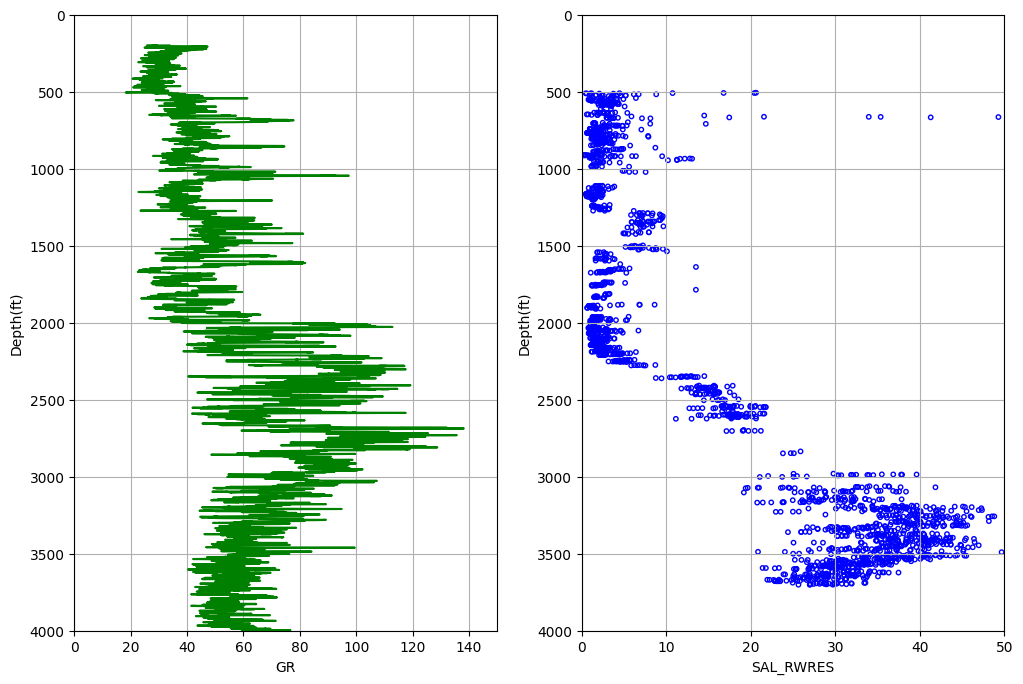

In [ ]:
def plotter():
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    logs = ['GR', 'SAL_RWRES']
    colors = ['green', 'blue']
    x_limits = [150, 50]  # X-axis limits for 'GR' and 'SAL_RWRES' respectively
    for i, log, color, x_limit in zip(range(2), logs, colors, x_limits):
        ax[i].set_ylim(0, 4000)
        if log == 'SAL_RWRES':
            ax[i].scatter(df_shorter[log], df_shorter.index, color=color, s=10, facecolors='none')
            ax[i].set_xlim(0, 50)
        else:
            ax[i].plot(df_shorter[log], df_shorter.index, color=color)
            ax[i].set_xlim(0, x_limit)
        ax[i].invert_yaxis()
        ax[i].set_xlabel(log)
        ax[i].set_ylabel("Depth(ft)")
        ax[i].grid()


plotter()


<ipython-input-89-cf62277066a0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shorter['SAL_RWRES_smoothed'] = smooth_data(df_shorter['SAL_RWRES'], window_size)


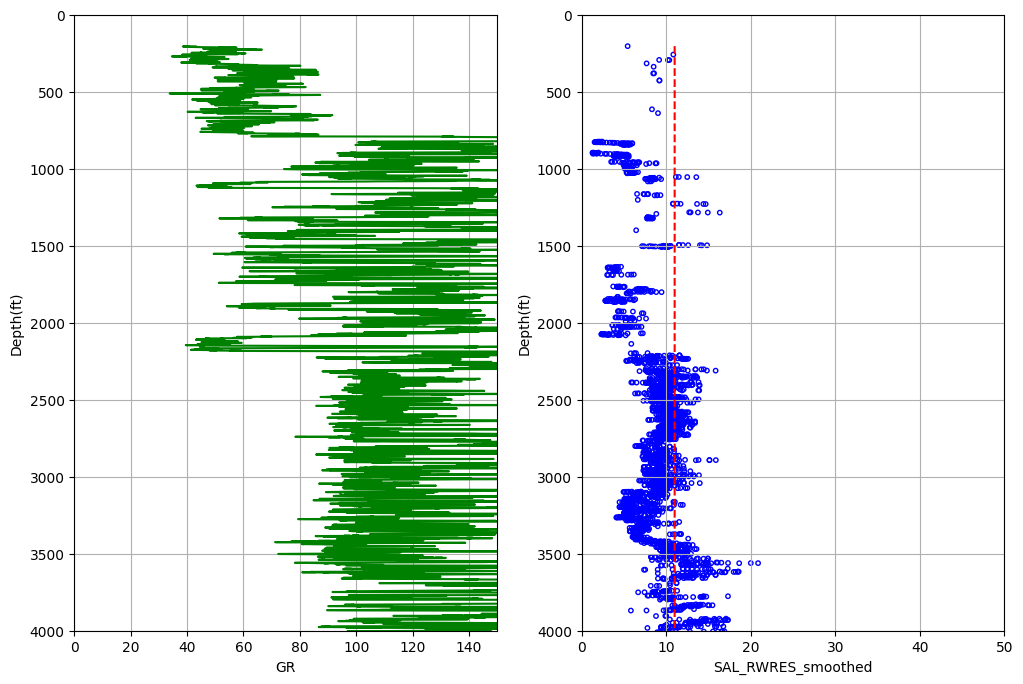

In [ ]:
def smooth_data(data, window):
    smoothed_data = np.convolve(data, np.ones(window)/window, mode='same')
    return smoothed_data


window_size = 3
df_shorter['SAL_RWRES_smoothed'] = smooth_data(df_shorter['SAL_RWRES'], window_size)

def create_average_line(data):
    average_line = np.ones(len(data)) * np.mean(data)
    return average_line


def plotter():
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    logs = ['GR', 'SAL_RWRES_smoothed']
    colors = ['green', 'blue']
    x_limits = [150, 50]  # X-axis limits for 'GR' and 'SAL_RWRES' respectively
    for i, log, color, x_limit in zip(range(2), logs, colors, x_limits):
        ax[i].set_ylim(0, 4000)
        if log == 'SAL_RWRES_smoothed':
            ax[i].scatter(df_shorter[log], df_shorter.index, color=color, s=10, facecolors='none')
            ax[i].set_xlim(0, 50)
        else:
            ax[i].plot(df_shorter[log], df_shorter.index, color=color)
            ax[i].set_xlim(0, x_limit)
        ax[i].invert_yaxis()
        ax[i].set_xlabel(log)
        ax[i].set_ylabel("Depth(ft)")
        ax[i].grid()

    average_line = create_average_line(df_clean['SAL_RWRES'])
    ax[i].plot(average_line, df_clean.index, color='red', linestyle='--')




plotter()

<ipython-input-90-f3e8b3eab0fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shorter['SAL_RWRES_smoothed'] = smooth_data(df_shorter['SAL_RWRES'], window_size)


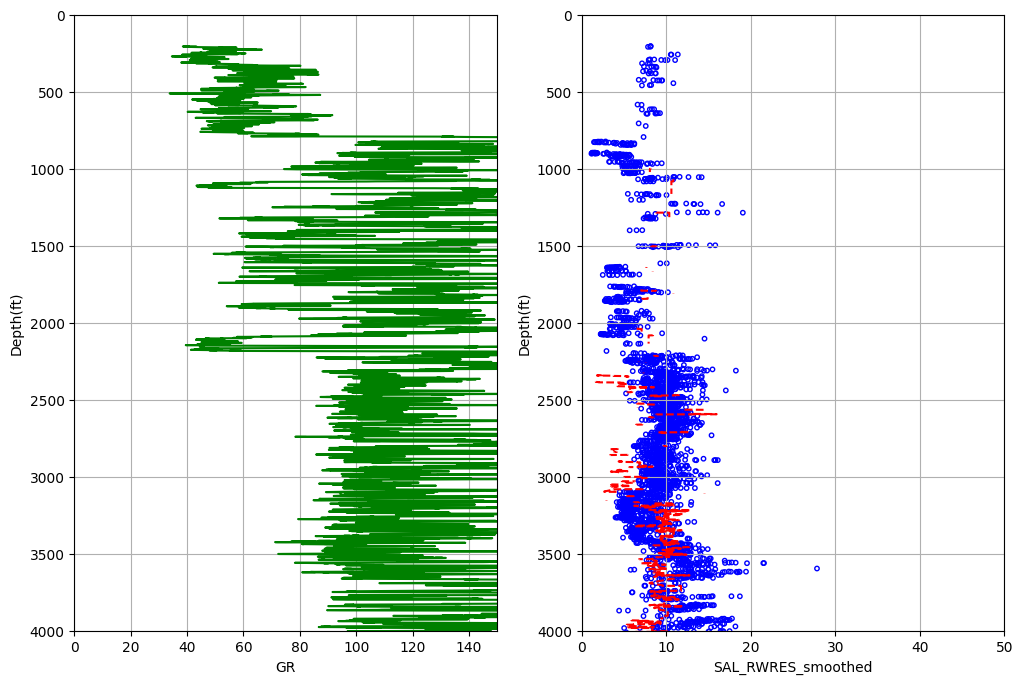

In [ ]:
def smooth_data(data, window):
    smoothed_data = np.convolve(data, np.ones(window)/window, mode='same')
    return smoothed_data


window_size = 1
df_shorter['SAL_RWRES_smoothed'] = smooth_data(df_shorter['SAL_RWRES'], window_size)

def create_average_line(data, step):
    average_line = []
    for i in range(0, len(data), step):
        average_line.extend([np.mean(data[i:i+step])] * step)
    return average_line[:len(data)]


def plotter():
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    logs = ['GR', 'SAL_RWRES_smoothed']
    colors = ['green', 'blue']
    x_limits = [150, 50]  # X-axis limits for 'GR' and 'SAL_RWRES' respectively
    for i, log, color, x_limit in zip(range(2), logs, colors, x_limits):
        ax[i].set_ylim(0, 4000)
        if log == 'SAL_RWRES_smoothed':
            ax[i].scatter(df_shorter[log], df_shorter.index, color=color, s=10, facecolors='none')
            ax[i].set_xlim(0, 50)
        else:
            ax[i].plot(df_shorter[log], df_shorter.index, color=color)
            ax[i].set_xlim(0, x_limit)
        ax[i].invert_yaxis()
        ax[i].set_xlabel(log)
        ax[i].set_ylabel("Depth(ft)")
        ax[i].grid()

    step_size = 5
    average_line = create_average_line(df_clean['SAL_RWRES'], step_size)
    ax[i].plot(average_line, df_clean.index, color='red', linestyle='--')




plotter()

<ipython-input-91-b96fb6d68ee9>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shorter[log] = remove_spikes(df_shorter[log])


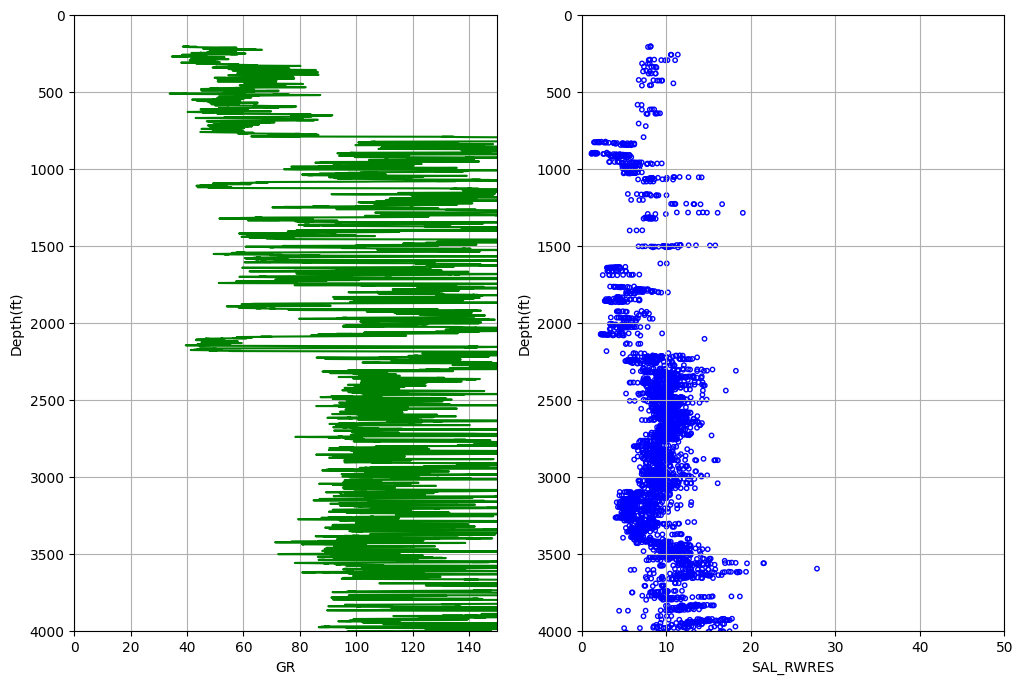

In [ ]:
from scipy.ndimage import median_filter

def remove_spikes(data, window_size=30, threshold=30):
    """
    Remove spikes from the data using median filtering.

    Parameters:
        data (pd.Series): The data from which spikes will be removed.
        window_size (int): The size of the median filter window.
        threshold (float): The number of standard deviations beyond which a data point is considered a spike.

    Returns:
        pd.Series: The data with spikes removed.
    """
    data_array = np.array(data, dtype=float)  # Convert Series to NumPy array with float data type
    median_filtered = median_filter(data_array, size=window_size)
    difference = np.abs(data_array - median_filtered)
    threshold_value = threshold * np.std(difference)
    data_no_spikes = data.copy()
    data_no_spikes[difference > threshold_value] = median_filtered[difference > threshold_value]

    return data_no_spikes


def plotter():
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    logs = ['GR', 'SAL_RWRES']
    colors = ['green', 'blue']
    x_limits = [150, 50]  # X-axis limits for 'GR' and 'SAL_RWRES' respectively

    for i, log, color, x_limit in zip(range(2), logs, colors, x_limits):
        ax[i].set_ylim(0, 4000)
        if log == 'SAL_RWRES':
            df_shorter[log] = remove_spikes(df_shorter[log])
            ax[i].scatter(df_shorter[log], df_shorter.index, color=color, s=10, facecolors='none')
            ax[i].set_xlim(0, 50)
        else:
            ax[i].plot(df_shorter[log], df_shorter.index, color=color)
            ax[i].set_xlim(0, x_limit)
        ax[i].invert_yaxis()
        ax[i].set_xlabel(log)
        ax[i].set_ylabel("Depth(ft)")
        ax[i].grid()

plotter()






In [ ]:

def remove_spikes(data, window_size=3, threshold=1):
    """
    Remove spikes from the data using median filtering.

    Parameters:
        data (pd.Series): The data from which spikes will be removed.
        window_size (int): The size of the median filter window.
        threshold (float): The number of standard deviations beyond which a data point is considered a spike.

    Returns:
        pd.Series: The data with spikes removed.
    """
    data_array = np.array(data, dtype=float)  # Convert Series to NumPy array with float data type
    median_filtered = median_filter(data_array, size=window_size)
    difference = np.abs(data_array - median_filtered)
    threshold_value = threshold * np.std(difference)
    data_no_spikes = data.copy()
    data_no_spikes[difference > threshold_value] = median_filtered[difference > threshold_value]

    # Plotting the data before and after spike removal
    plt.figure(figsize=(5, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(data.values, data.index, c='blue', edgecolors='black',  s=10, facecolors='none')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data Before Spike Removal')
    plt.xlim(0, 90)
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    plt.scatter(data_no_spikes.values, data.index,  c='blue', edgecolors='black', s=10, facecolors='none')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data After Spike Removal')
    plt.xlim(0, 90)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    return data_no_spikes

remove_spikes(df_shorter["SAL_RWRES"])

NameError: ignored

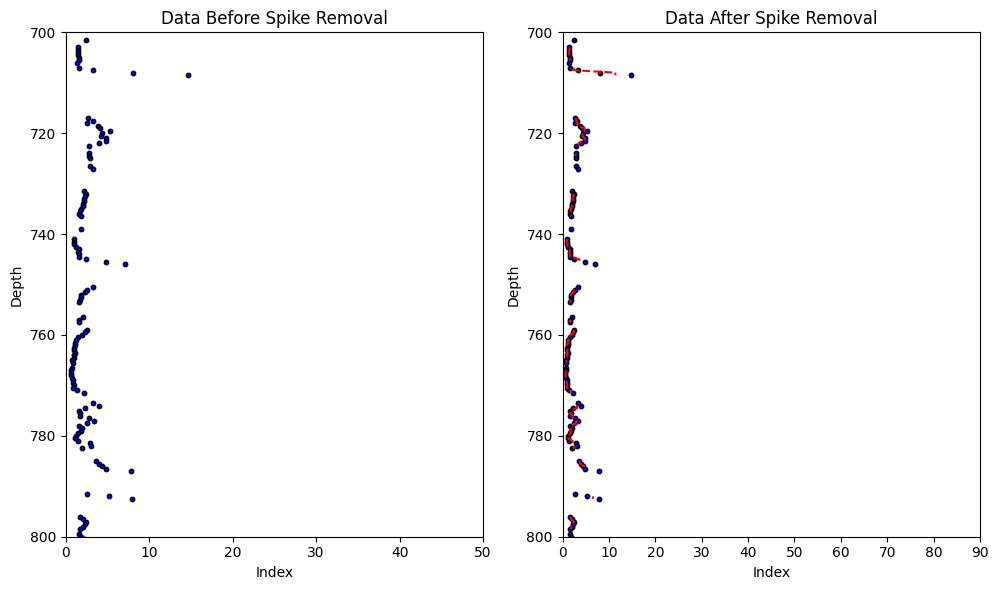

In [ ]:
def create_average_line(data, step):
    average_line = []
    for i in range(0, len(data), step):
        average_line.extend([np.mean(data[i:i+step])] * step)
    return average_line[:len(data)]


def remove_spikes(data, threshold=3):
    """
    Remove spikes from the data.

    Parameters:
        data (pd.Series): The data from which spikes will be removed.
        threshold (float): The number of standard deviations beyond which a data point is considered a spike.

    Returns:
        pd.Series: The data with spikes removed.
    """
    mean = data.mean()
    std = data.std()
    data_no_spikes = data.copy()
    data_no_spikes[np.abs(data - mean) > threshold * std] = np.nan
    return data_no_spikes

def plot_spikes(data, data_no_spikes):
    """
    Plot the data before and after spike removal.

    Parameters:
        data (pd.Series): The original data.
        data_no_spikes (pd.Series): The data with spikes removed.
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)  # Plotting data before spike removal
    plt.scatter(data.values, data.index, c='blue', edgecolors='black', s=10, facecolors='none')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data Before Spike Removal')
    plt.xlim(0, 50)
    plt.ylim(700, 800)
    plt.gca().invert_yaxis()  # Reverse the y-axis

    plt.subplot(1, 2, 2)  # Plotting data after spike removal
    plt.scatter(data_no_spikes.values, data_no_spikes.index, c='blue', edgecolors='black', s=10, facecolors='none')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data After Spike Removal')
    plt.xlim(0, 90)
    plt.ylim(700, 800)
    plt.gca().invert_yaxis()  # Reverse the y-axis

    step_size = 2
    average_line = create_average_line(data_no_spikes.values, step_size)
    plt.plot(average_line, data_no_spikes.index, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

# Remove spikes from the data
data_no_spikes = remove_spikes(df_shorter["SAL_RWRES"])

# Plot the data before and after spike removal
plot_spikes(df_shorter["SAL_RWRES"], data_no_spikes)




[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

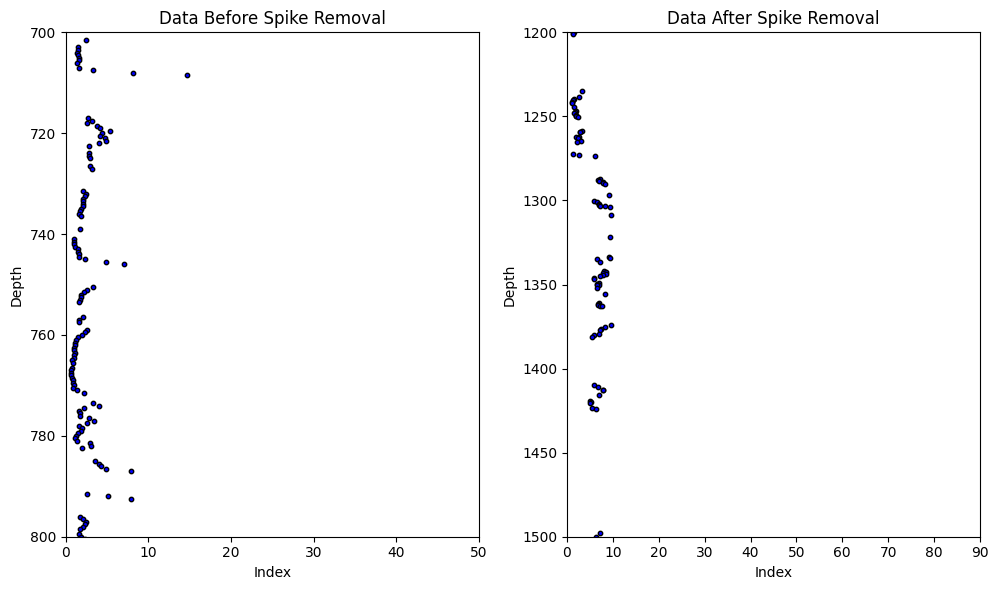

In [ ]:
"""def create_average_line(data, step):
    average_line = []
    for i in range(0, len(data), step):
        if i + step <= len(data):
            average_value = np.mean(data[i:i+step])
            average_line.extend([average_value] * step)
        else:
            # If the remaining data is less than the step size, compute the average for the remaining portion
            remaining_data = data[i:]
            average_value = np.mean(remaining_data)
            average_line.extend([average_value] * len(remaining_data))
    return average_line[:len(data)]"""


def create_average_line(data, step):
    average_line = []
    index = data.index.values
    #print(len(data)) #15259
    values = data.values

    for i in range(0, len(data), step):
        x = index[i:i+step]
        y = values[i:i+step]
        coeffs = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (line)
        line = np.polyval(coeffs, x)  # Evaluate the line for all index values
        average_line.extend(line)

    print(average_line)
    print(len(average_line))
    return average_line


def remove_spikes(data, threshold=3):
    """
    Remove spikes from the data.

    Parameters:
        data (pd.Series): The data from which spikes will be removed.
        threshold (float): The number of standard deviations beyond which a data point is considered a spike.

    Returns:
        pd.Series: The data with spikes removed.
    """
    mean = data.mean()
    std = data.std()
    data_no_spikes = data.copy()
    data_no_spikes[np.abs(data - mean) > threshold * std] = np.nan
    return data_no_spikes

def plot_spikes(data, data_no_spikes, average_line):
    """
    Plot the data before and after spike removal.

    Parameters:
        data (pd.Series): The original data.
        data_no_spikes (pd.Series): The data with spikes removed.
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)  # Plotting data before spike removal
    plt.scatter(data.values, data.index, c='blue', edgecolors='black', s=10, facecolors='none')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data Before Spike Removal')
    plt.xlim(0, 50)
    plt.ylim(700, 800)
    plt.gca().invert_yaxis()  # Reverse the y-axis

    plt.subplot(1, 2, 2)  # Plotting data after spike removal
    plt.scatter(data_no_spikes.values, data_no_spikes.index, c='blue', edgecolors='black', s=10, facecolors='none')
    plt.plot(average_line, data_no_spikes.index, color='red', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Depth')
    plt.title('Data After Spike Removal')
    plt.xlim(0, 90)
    plt.ylim(1200,1500)
    plt.gca().invert_yaxis()  # Reverse the y-axis

    plt.tight_layout()
    plt.show()

# Remove spikes from the data
data_no_spikes = remove_spikes(df_shorter["SAL_RWRES"])

# Generate the average line
#step = int(len(df_shorter["SAL_RWRES"]) * 0.1)  # Adjust step size as needed
average_line = create_average_line(data_no_spikes, 10)

# Plot the data before and after spike removal with the average line overlaid
plot_spikes(df_shorter["SAL_RWRES"], data_no_spikes, average_line)

# Plot the data before and after spike removal
#plot_spikes(df_shorter["SAL_RWRES"], data_no_spikes)

In [ ]:
#@title Procesamiento de datos

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=["start","end", "min_sp", "max_sp"])

# Iterate over each depth interval
for index, interval in df_intervals.iterrows():
    start_depth = interval["start"]
    end_depth = interval["end"]

    # Extract the subset of data based on the depth interval
    subset = df_las[(df_las[Profundidad] >= start_depth) & (df_las[Profundidad] <= end_depth)]

    # Exclude the rows with SPC equal to -9999
    subset = subset[subset[Variable] != -9999]

    # Calculate the minimum and maximum values of SP within the subset
    min_sp = subset[Variable].min()
    max_sp = subset[Variable].max()

    # Add the interval, minimum value, and maximum value to the result DataFrame
    interval_df = pd.DataFrame({
        "start": [start_depth],
        "end": [end_depth],
        "min_sp": [min_sp],
        "max_sp": [max_sp]})

    result_df = pd.concat([result_df, interval_df], ignore_index=True)


# Save the result DataFrame to a CSV file
result_df.to_csv(f"/content/output/{File}_SSP.csv", index=False, sep=";")



Index: [454.  454.5 455.  455.5 456.  456.5 457.  457.5 458.  458.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Index: [459.  459.5 460.  460.5 461.  461.5 462.  462.5 463.  463.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Index: [464.  464.5 465.  465.5 466.  466.5 467.  467.5 468.  468.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Index: [469.  469.5 470.  470.5 471.  471.5 472.  472.5 473.  473.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Index: [474.  474.5 475.  475.5 476.  476.5 477.  477.5 478.  478.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Index: [479.  479.5 480.  480.5 481.  481.5 482.  482.5 483.  483.5]
data: [nan nan nan nan nan nan nan nan nan nan]
line: [nan nan nan nan nan nan nan nan nan nan]

Inde

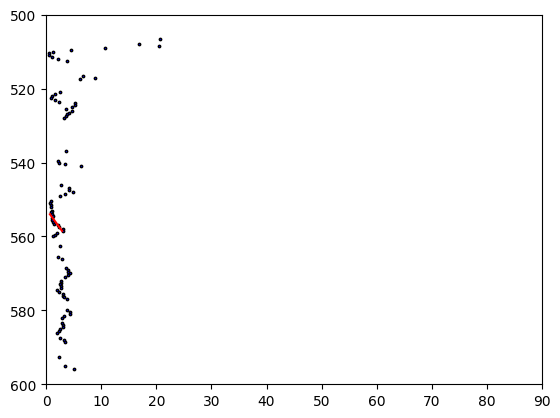

In [ ]:

def create_average_line(data, step):
    average_line = []
    index = data.index.values
    #print(len(data)) #15259
    values = data.values

    for i in range(0, len(data), step):
        x = index[i:i+step]
        y = values[i:i+step]
        coeffs = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (line)
        line = np.polyval(coeffs, x)  # Evaluate the line for all index values
        average_line.extend(line)
        if 500<i<1000:
          print("Index:",x)
          print("data:", y)
          print("line:", line)
          print("============== \n")

    print(len(line))
    return average_line

average_line = create_average_line(data_no_spikes, 10)
print(len(average_line))
plt.scatter(data_no_spikes.values, data_no_spikes.index, c='blue', edgecolors='black', s=3, facecolors='none')
plt.plot(average_line, data_no_spikes.index, color='red', linestyle='-')
plt.xlim(0, 90)
plt.ylim(500,600)
plt.gca().invert_yaxis()



##Working code

##TODO:
###FINISH THE INDEX
* CHECK both lisa and yari to see if this method makes sense, before continuing
* Get an index, could be substracting slope consecutive values and linking that to a depth
* Get the number of breaks that are above some umbral
* Add the zones
* Generate a df? with zone number of positive breakes

###REFACTORING
* Organize and integrate all the code above
* Make the code interactive with google colab input to change parameters
* Organize the working functions apart

150
5250


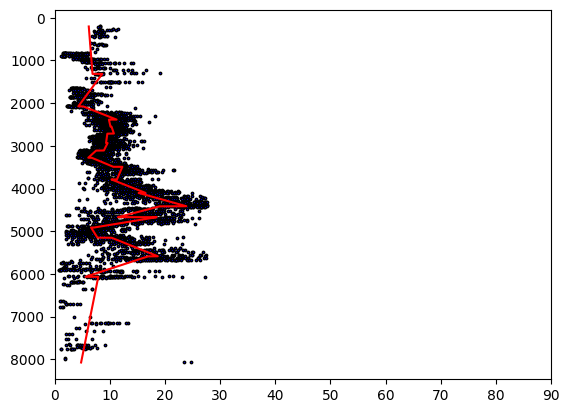

In [ ]:
#Function to get the average lines per sector given a step is working
def create_average_line(data, step):
    data = data.dropna()
    average_line = []
    index = data.index.values
    #print(len(data)) #15259
    values = data.values

    for i in range(0, len(data), step):
        x = index[i:i+step]
        y = values[i:i+step]
        coeffs = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (line)
        line = np.polyval(coeffs, x)  # Evaluate the line for all index values
        average_line.extend(line)
        #if 500<i<1000:
          #print("Index:",x)
          #print("data:", y)
          #print("line:", line)
          #print("============== \n")

    print(len(line))
    return average_line

average_line = create_average_line(data_no_spikes, 300)
print(len(average_line))
plt.scatter(data_no_spikes.values, data_no_spikes.index, c='blue', edgecolors='black', s=3, facecolors='none')
plt.plot(average_line, data_no_spikes.dropna().index, color='red', linestyle='-')
plt.xlim(0, 90)
#plt.ylim(500,600)
plt.gca().invert_yaxis()

171
[-0.0009078855849096759, 0.0063353394087408725, 0.016919957083246156, -0.005186004993336863, 0.0026563698258102357, 0.04724193278169703, 0.023324158354475398, 0.014740912962804867, 0.05927376503680692, -0.04127871289314012, -0.01760590313990472]
[635.5, 842.5, 1198.5, 1821.5, 2099.0, 2276.0, 3062.0, 3257.0, 3401.5, 3530.5, 3642.0]


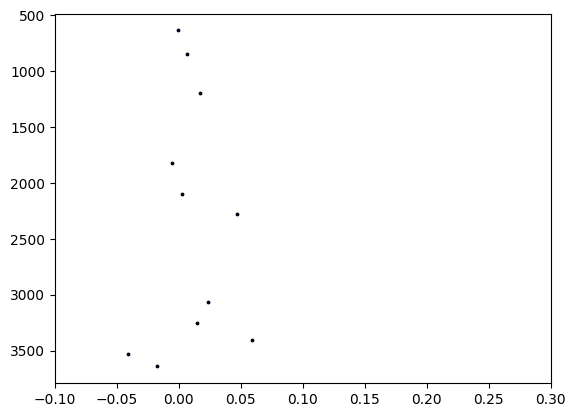

2171


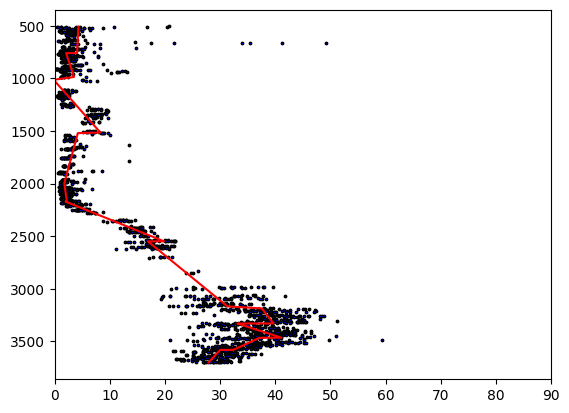

In [ ]:
#Function to get the average lines per sector given a step is working
def create_average_line(data, step):
    data = data.dropna()
    average_line = []
    slopes = []
    slope_depth = []
    index = data.index.values
    #print(len(data)) #15259
    values = data.values

    for i in range(0, len(data), step):
        x = index[i:i+step]
        y = values[i:i+step]
        coeffs = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (line)
        line = np.polyval(coeffs, x)  # Evaluate the line for all index values
        average_line.extend(line)
        slopes.append(coeffs[0])
        if len(x) > 0:
            slope_depth.append(x[int(len(x)/2)])
        else:
            slope_depth.append(np.nan)
        #if 500<i<1000:
          #print("Index:",x)
          #print("data:", y)
          #print("line:", line)
          #print("============== \n")

    print(len(line))
    print(slopes)
    print(slope_depth)
    plt.scatter(slopes, slope_depth, c='blue', edgecolors='black', s=3, facecolors='none')
    plt.gca().invert_yaxis()
    plt.xlim(-0.1, 0.3)
    plt.show()
    return average_line

average_line = create_average_line(data_no_spikes, 200)
print(len(average_line))
plt.scatter(data_no_spikes.values, data_no_spikes.index, c='blue', edgecolors='black', s=3, facecolors='none')
plt.plot(average_line, data_no_spikes.dropna().index, color='red', linestyle='-')
plt.xlim(0, 90)
#plt.ylim(500,600)
plt.gca().invert_yaxis()


#Summaries proccesor

##Loading summaries

In [ ]:
Csv_Url = "/content/input/summaries/Result_CSBE_TVD_12052022 - filter - noKB.csv"
df_intervals = pd.read_csv(Csv_Url, sep=";").reset_index()
df_intervals.head()

,index,Well,Zones,Flag Name,Top,Bottom,Reference unit,Gross,Net,Not Net,Unknown,Net to Gross,Net to (Gross-Unknown),POR-TH,Av_Shale Volume,Av_Porosity,Av_DCAL,Av_DRHO,Av_SAL_RW,Field
0,0,CSBE1228,Base Conglomerado,ROCK,432.63,736.76,FT,304.13,94.76,209.37,0.0,0.312,0.312,30.962,0.203,0.327,0.894,-0.008,8.747,CASABE
1,1,CSBE1228,Base Conglomerado,RES,432.63,736.76,FT,304.13,92.76,208.87,2.5,0.305,0.308,29.817,0.206,0.321,0.876,-0.008,8.810,CASABE
2,2,CSBE1228,Base Conglomerado,PAY,432.63,736.76,FT,304.13,92.76,208.87,2.5,0.305,0.308,29.817,0.206,0.321,0.876,-0.008,8.810,CASABE
3,3,CSBE1228,GR-ENREJADO,ROCK,736.76,1096.27,FT,359.51,13.74,345.77,0.0,0.038,0.038,4.524,0.195,0.329,1.028,-0.003,12.946,CASABE
4,4,CSBE1228,GR-ENREJADO,RES,736.76,1096.27,FT,359.51,13.74,345.77,0.0,0.038,0.038,4.524,0.195,0.329,1.028,-0.003,12.946,CASABE


In [ ]:
directory = "/content/input/summaries"  # Directory path
files = os.listdir(directory)  # List all files in the directory

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the files
for file in files:
    if file.endswith(".csv"):  # Consider only CSV files
        file_path = os.path.join(directory, file)  # Get the full file path
        df = pd.read_csv(file_path, sep=";")  # Read the CSV file
        dfs.append(df)  # Append the dataframe to the list


# Concatenate all dataframes into one
concatenated_df = pd.concat(dfs, ignore_index=True)
#Drop Nan values in 'Net' column
concatenated_df.dropna(subset=['Net'], inplace=True)
#Drop values of the PAY and ROCK flags
concatenated_df.drop(concatenated_df[(concatenated_df['Flag Name'] == 'PAY') | (concatenated_df['Flag Name'] == 'ROCK')].index, inplace=True)
# Display the resulting concatenated dataframe
print(concatenated_df.head(100))


         Well              Zones Flag Name       Top    Bottom Reference unit  \
4    CANT0039        GR-ENREJADO       RES  1077.969  1385.639             ft   
7    CANT0039            GR-HIEL       RES  1385.639  1712.019             ft   
10   CANT0039     GR-CHONTORALES       RES  1712.019  2185.416             ft   
13   CANT0039          GR-LLUVIA       RES  2185.416  2345.596             ft   
16   CANT0039        Fm Colorado       RES  2345.596  3622.380             ft   
..        ...                ...       ...       ...       ...            ...   
331  CSBE1094          GR-LLUVIA       RES  2233.480  2300.000             FT   
334  CSBE1094        Fm Colorado       RES  2300.000  2611.000             FT   
337  CSBE1132  Base Conglomerado       RES   419.993   554.314             FT   
340  CSBE1132            GR-HIEL       RES   554.314   927.764             FT   
343  CSBE1132     GR-CHONTORALES       RES   927.764  2105.592             FT   

        Gross      Net   No

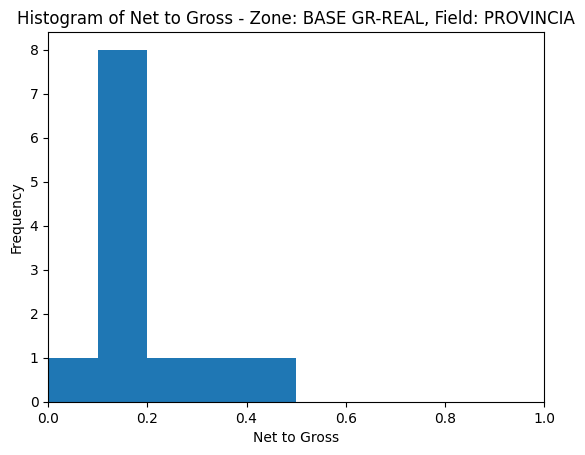

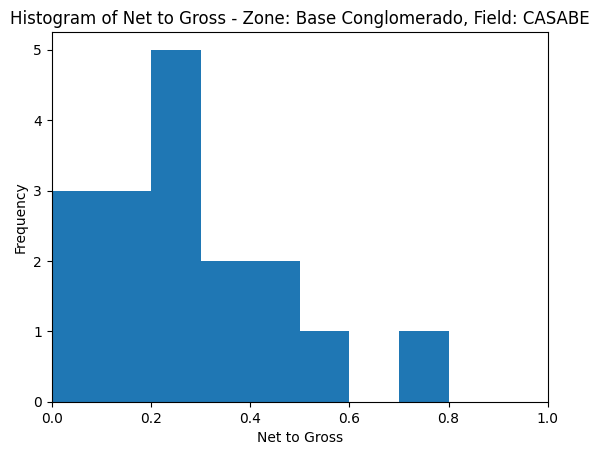

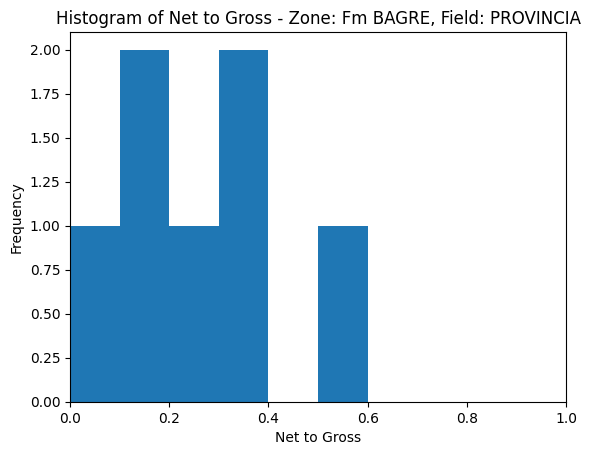

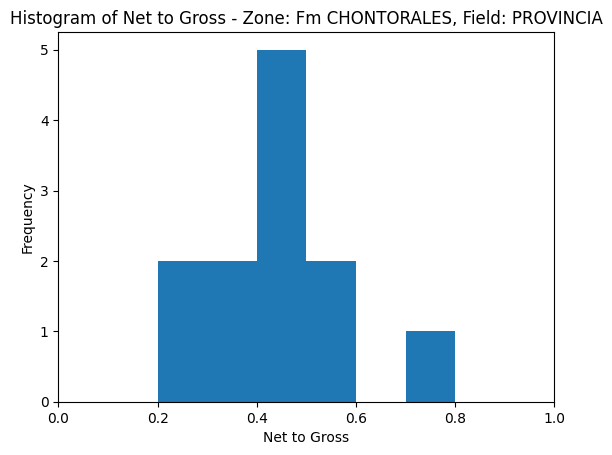

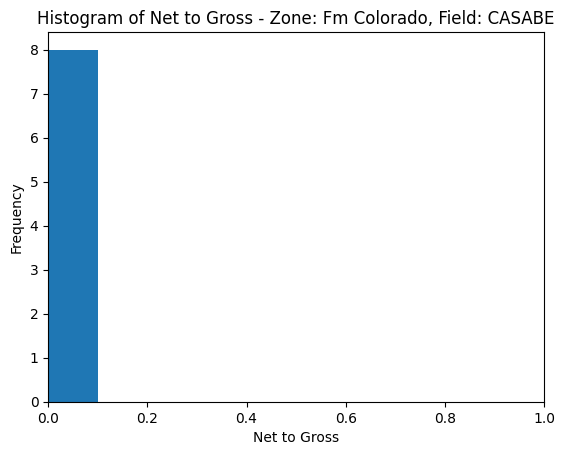

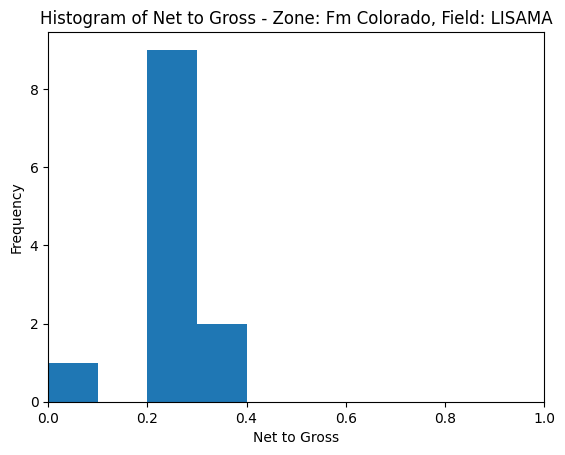

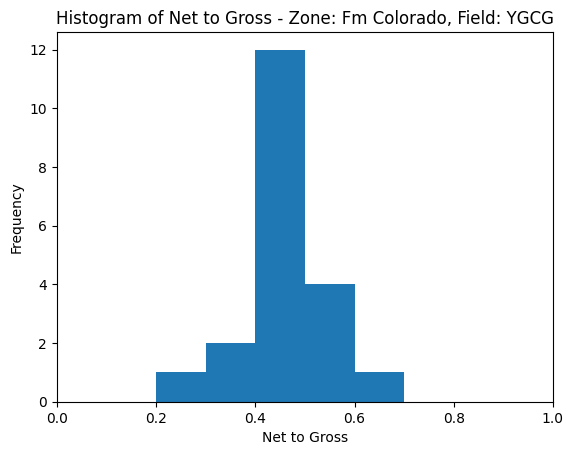

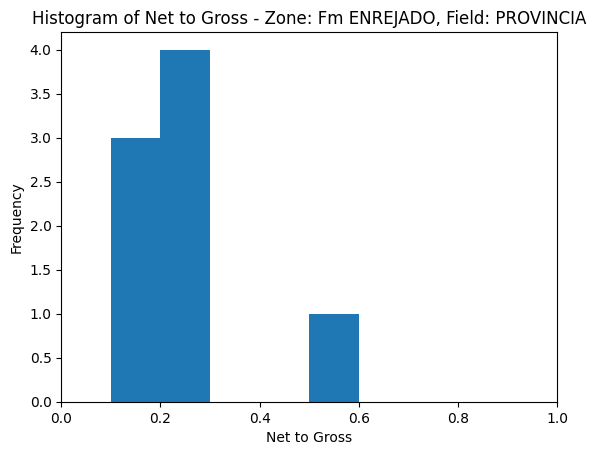

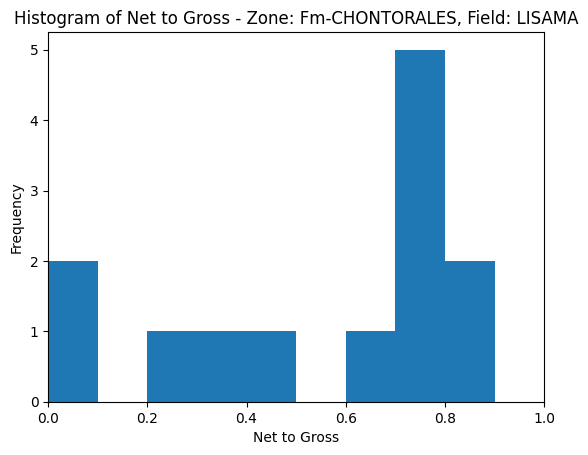

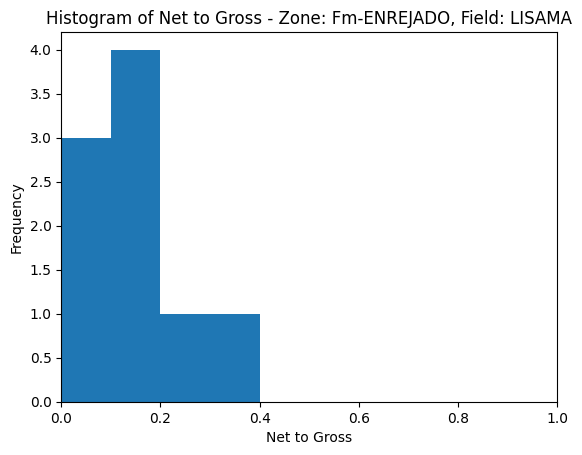

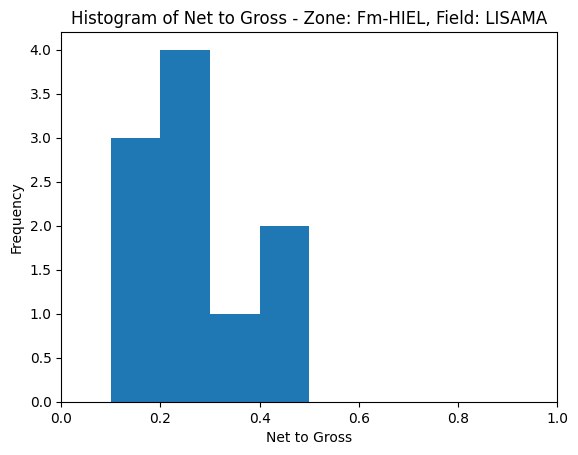

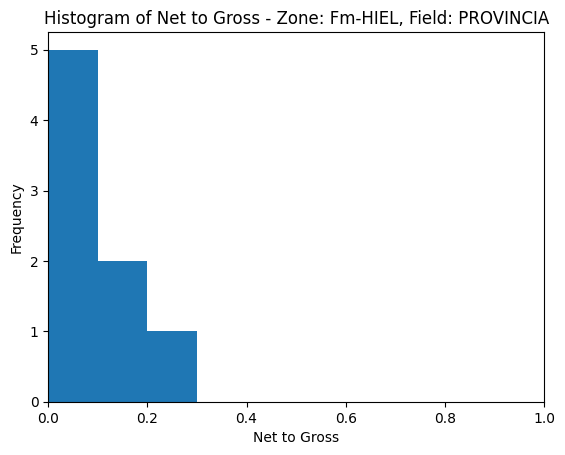

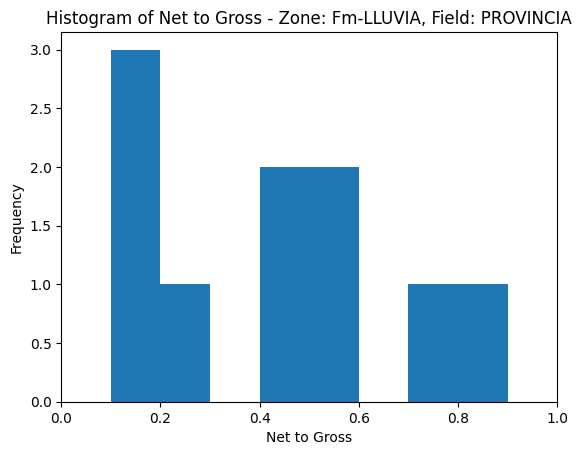

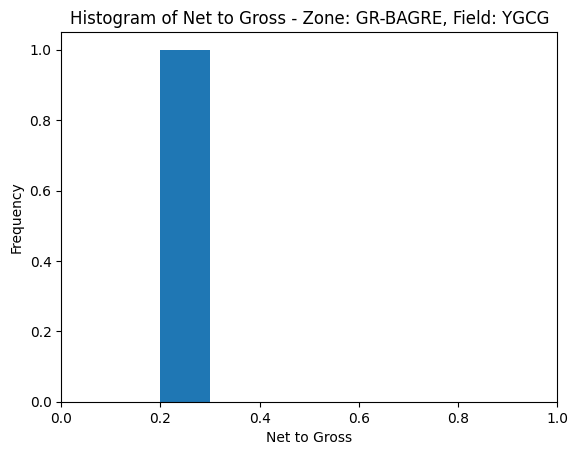

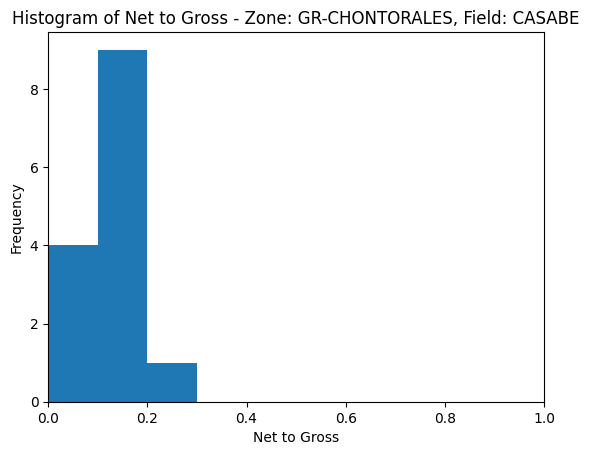

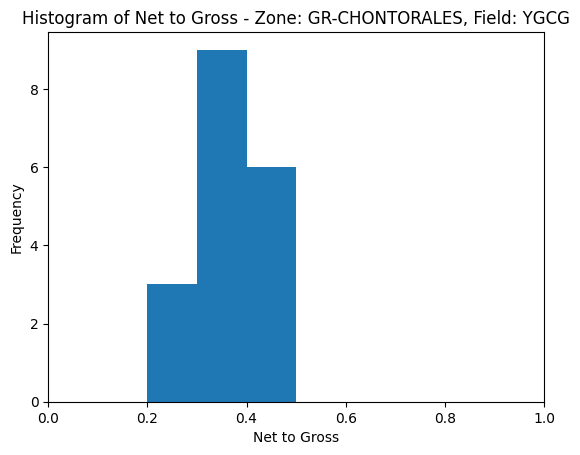

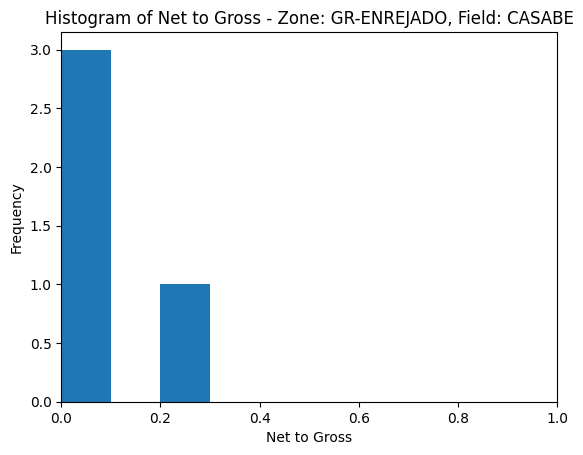

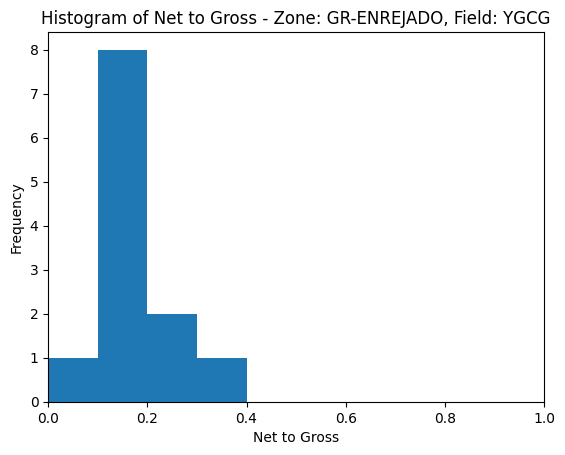

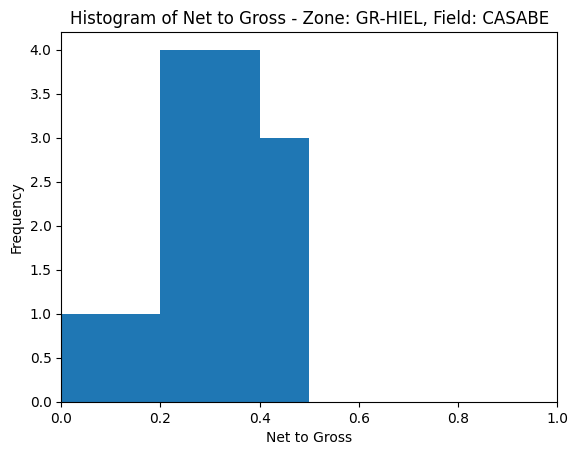

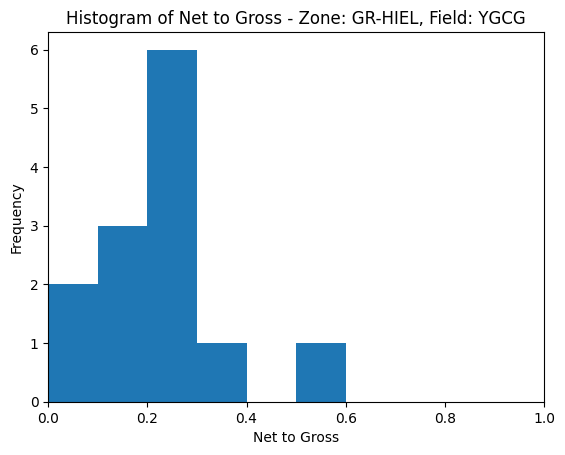

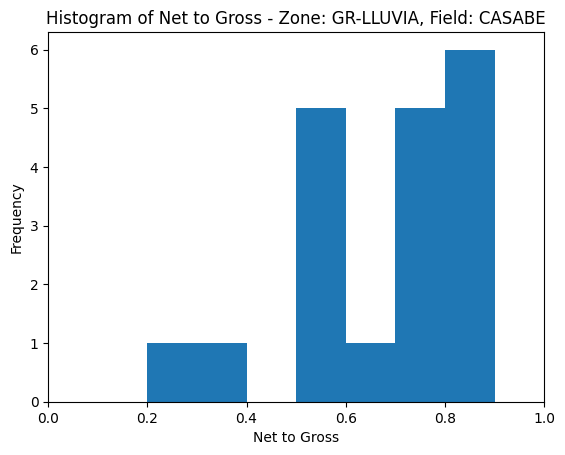

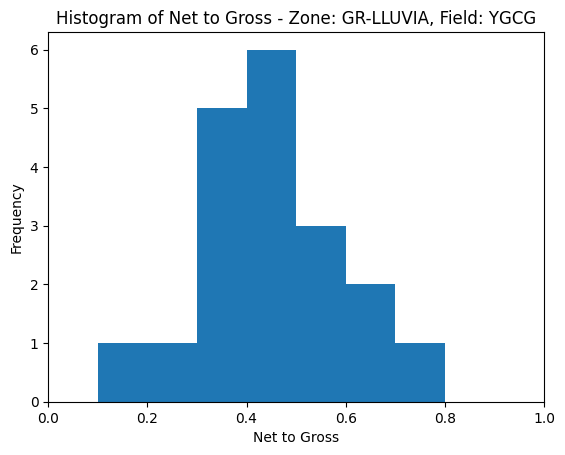

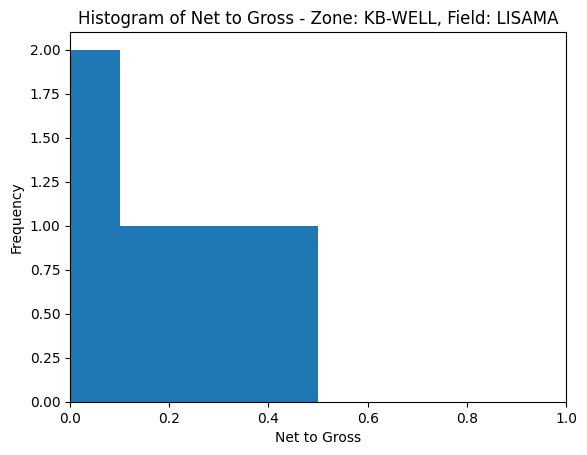

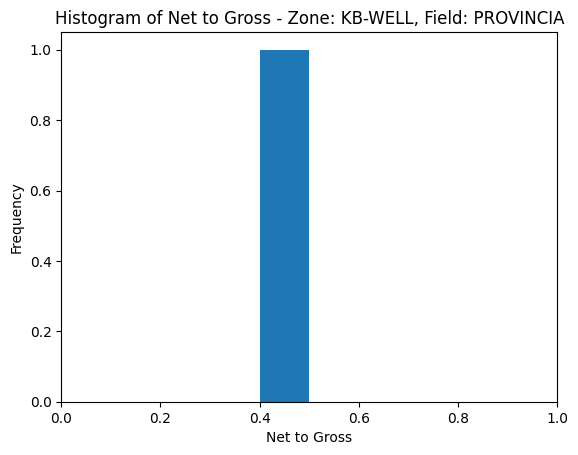

In [ ]:
# Group the data by "Zones" and "Field"
grouped_df = concatenated_df.groupby(['Zones', 'Field'])

# Iterate over each group
for group_name, group_data in grouped_df:
    zone, field = group_name

    # Filter the data for the current zone and field
    filtered_data = group_data['Net to Gross']

    # Create a histogram
    plt.hist(filtered_data, bins=10, range=(0, 1))

    # Set plot title and labels
    plt.title(f"Histogram of Net to Gross - Zone: {zone}, Field: {field}")
    plt.xlabel("Net to Gross")
    plt.ylabel("Frequency")

    # Set x-axis limits
    plt.xlim(0, 1)

    # Show the plot
    plt.show()


In [ ]:
shutil.make_archive("/content/zip_SSP", 'zip',"/content/output")

'/content/zip_SSP.zip'